## Fraud Detection Classification Problem using Quantative and Qualitative Features

In [1]:
# Set Directory
import os
os.getcwd()

'C:\\Users\\Sumanth William Laza\\OneDrive\\A_DataScienceProgram\\A_INSOFE\\A_MiTH'

In [180]:
import numpy as np
import pandas as pd

# 1. Preprocessing Libraries
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder    #Dummification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    #NEW!
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold    #Hyperparameter tuning, StratifiedKFold
# another way to cross-validate
from sklearn.compose import ColumnTransformer


# 2. Algorithm Import
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import AdaBoostClassifier


# 3. Evaluation Library
from sklearn.metrics import confusion_matrix

# 4. Viz Lib
import matplotlib.pyplot as plt 
import seaborn as sns

# 5. Misc Lib
# !pip install imblearn
from imblearn.over_sampling import SMOTE    #Data/Class imbalance
import random
random.seed(123)
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Train Data Reading
m_train_data = pd.read_csv(filepath_or_buffer = 'train_merchant_data-1561627820784.csv', sep = ",", header = 0)
o_train_data = pd.read_csv(filepath_or_buffer = 'train_order_data-1561627847149.csv', sep = ",", header = 0)
y_train_data = pd.read_csv(filepath_or_buffer = 'train-1561627878332.csv', sep = ",", header = 0)
print(m_train_data.shape)
print(o_train_data.shape)
print(y_train_data.shape)


#Test Data Reading   
m_test_data = pd.read_csv(filepath_or_buffer = 'test_merchant_data-1561627903902.csv', sep = ",", header = 0)
o_test_data = pd.read_csv(filepath_or_buffer = 'test_order_data-1561627931868.csv', sep = ",", header = 0)
y_test_data = pd.read_csv(filepath_or_buffer = 'test-1561627952093.csv', sep = ",", header = 0)
print(m_test_data.shape)
print(o_test_data.shape)
print(y_test_data.shape)   # 'y' Test Data is unlabelled

(54213, 7)
(54213, 7)
(54213, 2)
(13554, 7)
(13554, 7)
(13554, 1)


**Understanding the Dataset**

In [4]:
print(m_train_data.columns, "\n")
print(o_train_data.columns, "\n")   #Join on 'Merchant_ID'

print(m_train_data.dtypes, "\n")   #Mixture of Integers and Objects
print(o_train_data.dtypes)

Index(['Ecommerce_Provider_ID', 'Merchant_ID', 'Merchant_Registration_Date',
       'Registered_Device_ID', 'Gender', 'Age', 'IP_Address'],
      dtype='object') 

Index(['Customer_ID', 'Order_ID', 'Date_of_Order', 'Order_Value_USD',
       'Order_Source', 'Order_Payment_Method', 'Merchant_ID'],
      dtype='object') 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
dtype: object 

Customer_ID              int64
Order_ID                object
Date_of_Order           object
Order_Value_USD          int64
Order_Source            object
Order_Payment_Method    object
Merchant_ID              int64
dtype: object


In [5]:
m_train_data.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address
0,1746213,50448,01-05-18 21:15,VATQMMZTVOZUT,F,39,48.151.136.76
1,1746213,338754,14-04-18 10:13,LJCILLBRQZNKS,M,35,94.9.145.169
2,1746213,291127,20-06-18 7:44,JFVHSUGKDAYZV,F,40,58.94.157.121
3,1746213,319919,27-06-18 1:41,WFRXMPLQYXRMY,M,37,193.187.41.186
4,1746213,195911,05-01-18 0:55,GGHKWMSWHCMID,F,27,125.96.20.172


In [6]:
m_train_data.describe()  #No NA's in numerical data

,Ecommerce_Provider_ID,Merchant_ID,Age
count,54213.0,54213.000000,54213.000000
mean,1746213.0,200395.176212,33.122240
std,0.0,115398.486895,8.630091
min,1746213.0,2.000000,18.000000
25%,1746213.0,100997.000000,27.000000
50%,1746213.0,200574.000000,32.000000
75%,1746213.0,300407.000000,39.000000
max,1746213.0,399993.000000,72.000000


In [7]:
m_train_data.describe(include = 'object')

,Merchant_Registration_Date,Registered_Device_ID,Gender,IP_Address
count,54213,54213,54213,54213
unique,51023,51291,2,52028
top,06-01-18 12:10,VIPZYJGMVMXOF,M,32.67.159.62
freq,12,9,31761,9


In [8]:
o_train_data.describe()   #No NA's in o_train_data (Quant)

,Customer_ID,Order_Value_USD,Merchant_ID
count,54213.000000,54213.000000,54213.000000
mean,137966.285208,92.230240,200395.176212
std,15563.516156,45.673263,115398.486895
min,111234.000000,22.000000,2.000000
25%,124471.000000,55.000000,100997.000000
50%,137864.000000,88.000000,200574.000000
75%,151405.000000,122.000000,300407.000000
max,165000.000000,385.000000,399993.000000


In [9]:
o_train_data.describe(include = 'object')

,Order_ID,Date_of_Order,Order_Source,Order_Payment_Method
count,54213,54213,54213,54213
unique,54213,54161,3,5
top,02394823581e,2018-04-14 06:17:38,SEO,Credit Card
freq,1,2,21884,21844


**Merging Dataframes on Merchant_ID**

In [10]:
train_data = pd.merge(left = m_train_data, right = o_train_data, how = 'outer', on = 'Merchant_ID')
train_data = pd.merge(left = train_data, right = y_train_data, how = 'outer', on = 'Merchant_ID')

test_data = pd.merge(left = m_test_data, right = o_test_data, how = 'outer', on = 'Merchant_ID')
test_data = pd.merge(left = test_data, right = y_test_data, how = 'outer', on = 'Merchant_ID')

In [11]:
print(train_data.shape, '\n')
print(train_data.dtypes)

(54213, 14) 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
dtype: object


In [12]:
print(test_data.shape, '\n')
print(test_data.dtypes)

(13554, 13) 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
dtype: object


In [13]:
train_data.describe(include = 'int64')
# from pandas.plotting import table # EDIT: see deprecation warnings below

# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, train_data.describe())  # where df is your data frame

# plt.savefig('train_data_describe.png')

,Ecommerce_Provider_ID,Merchant_ID,Age,Customer_ID,Order_Value_USD,Fraudster
count,54213.0,54213.000000,54213.000000,54213.000000,54213.000000,54213.00000
mean,1746213.0,200395.176212,33.122240,137966.285208,92.230240,0.09269
std,0.0,115398.486895,8.630091,15563.516156,45.673263,0.29000
min,1746213.0,2.000000,18.000000,111234.000000,22.000000,0.00000
25%,1746213.0,100997.000000,27.000000,124471.000000,55.000000,0.00000
50%,1746213.0,200574.000000,32.000000,137864.000000,88.000000,0.00000
75%,1746213.0,300407.000000,39.000000,151405.000000,122.000000,0.00000
max,1746213.0,399993.000000,72.000000,165000.000000,385.000000,1.00000


### Pre-Processing Data and Exploratory Data Analysis

Pre-processing steps of the Train Data will be Applied to Test Data respectively. 

**Notes on Quantative Features**

'Merchant_ID', 'Customer_ID' will be converted to dtype 'object'.

'Ecommerce_Provider_ID' will be dropped due to No Information Gain.

In [14]:
train_data.drop(labels = 'Ecommerce_Provider_ID', axis = 1, inplace = True)
test_data.drop(labels = 'Ecommerce_Provider_ID', axis = 1, inplace = True)

In [15]:
train_data.shape

(54213, 13)

In [16]:
train_data

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
0,50448,01-05-18 21:15,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0
1,338754,14-04-18 10:13,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0
2,291127,20-06-18 7:44,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0
3,319919,27-06-18 1:41,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0
4,195911,05-01-18 0:55,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0
5,51878,29-07-18 5:40,YSUUQMHOIJZHJ,M,30,10.119.144.96,119105,942386c5ab2c,2018-10-11 09:41:51,75,Ads,Credit Card,0
6,205612,03-02-18 5:37,VOQNWQHJUKFSZ,F,28,135.121.143.189,150927,f5135bb9ab13,2018-03-27 20:06:24,65,SEO,Credit Card,0
7,300823,24-02-18 12:16,BQKBQIXSRMCHT,M,31,106.24.64.41,142294,d6f648eb802f,2018-04-12 02:19:59,152,SEO,Internet Banking,0
8,172822,22-01-18 12:29,MKGAJACYBWCXO,F,27,160.16.202.244,155784,0f98e4cfd92d,2018-02-02 16:39:03,80,SEO,Debit Card,1
9,241476,11-01-18 22:05,JJHGNMWRZRCML,M,41,93.33.235.39,138451,86ffa45527dc,2018-01-13 22:05:16,155,Ads,Credit Card,1


In [17]:
train_data[['Merchant_ID', 'Customer_ID']] = train_data[['Merchant_ID', 'Customer_ID']].astype('object') 
test_data[['Merchant_ID', 'Customer_ID']] = test_data[['Merchant_ID', 'Customer_ID']].astype('object')
print(train_data.dtypes, '\n')
print(test_data.dtypes)

Merchant_ID                   object
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                   object
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
dtype: object 

Merchant_ID                   object
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                   object
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
dtype: object


In [18]:
train_data.describe(include = 'object')

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Source,Order_Payment_Method
count,54213,54213,54213,54213,54213,54213,54213,54213,54213,54213
unique,54213,51023,51291,2,52028,34081,54213,54161,3,5
top,367309,06-01-18 12:10,VIPZYJGMVMXOF,M,32.67.159.62,111658,02394823581e,2018-08-11 00:46:11,SEO,Credit Card
freq,1,12,9,31761,9,7,1,2,21884,21844


Percentage Distribution of Order Sources

In [19]:
train_data['Order_Source'].value_counts(normalize = True)

SEO       0.403667
Ads       0.392138
Direct    0.204195
Name: Order_Source, dtype: float64

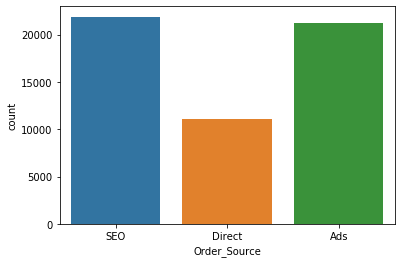

SEO       21884
Ads       21259
Direct    11070
Name: Order_Source, dtype: int64

In [20]:
sns.countplot(x='Order_Source', data=train_data)
plt.show()
train_data.Order_Source.value_counts()

Distribution of 'Age' is fairly symmetrical. Mean = 33.12, Median = 32

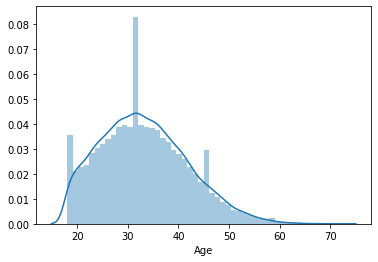

In [21]:
# Check distribution of age
# Density Curve + Histogram, shows distribution of Continuous Feature
%matplotlib inline
sns.distplot(train_data["Age"]) #NT: y is percentage count 

In [22]:
train_data['Order_Payment_Method'].value_counts(normalize = True)

Credit Card         0.402929
Internet Banking    0.243355
Debit Card          0.167303
E-wallet            0.161197
Cash On Delivery    0.025215
Name: Order_Payment_Method, dtype: float64

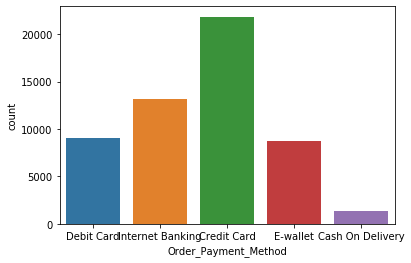

Credit Card         21844
Internet Banking    13193
Debit Card           9070
E-wallet             8739
Cash On Delivery     1367
Name: Order_Payment_Method, dtype: int64

In [23]:
sns.countplot(x='Order_Payment_Method', data=train_data)
plt.show()
train_data.Order_Payment_Method.value_counts()

### Feature Engineering

In [25]:
f# !pip install maxminddb-geolite2

from geolite2 import geolite2
geo = geolite2.reader()

def get_country(ip):
    try :
        x = geo.get(ip)
    except ValueError:   #Faulty or improper IP value
        return np.nan
    try:
        return x['country']['names']['en'] if x is not None else np.nan
    except KeyError: 
        return np.nan
    
def get_city(ip):
    try:
        x = geo.get(ip)
    except ValueError:   #if Value passed is faulty
        return np.nan
    
    try:
        return x['city']['names']['en'] if x is not None  else np.nan
    except KeyError:  #if Dictionary indexing is faulty 
        return np.nan
    
def get_subdivisions(ip):
    try:
        x = geo.get(ip)
    except ValueError:   #if Value passed is faulty
        return np.nan
    
    try:
        return x['subdivisions'][0]['names']['en'] if x is not None  else np.nan
    except KeyError:  #if Dictionary indexing is faulty 
        return np.nan

def get_continent(ip):
    try:
        x = geo.get(ip)
    except ValueError:   #if Value pafssed is faulty
        return np.nan
    
    try:
        return x['continent']['names']['en'] if x is not None  else np.nan
    except KeyError:  #if Dictionary indexing is faulty 
        return np.nan

In [ ]:
import time

s_time = time.time()
#apply(fn) applies fn. on all pd.series elements
train_data['country'] = train_data.loc[:,'IP_Address'].apply(get_country)  #Time:  41.6 s
test_data['country'] = test_data.loc[:,'IP_Address'].apply(get_country)   #Time: 7.71 s
train_data['Continent'] = train_data.loc[:,'IP_Address'].apply(get_continent)
test_data['Continent'] = test_data.loc[:,'IP_Address'].apply(get_continent)
train_data['Sub_Divisions'] = train_data.loc[:,'IP_Address'].apply(get_subdivisions)
test_data['Sub_Divisions'] = test_data.loc[:,'IP_Address'].apply(get_subdivisions)
train_data['City'] = train_data.loc[:,'IP_Address'].apply(get_city)
test_data['City'] = test_data.loc[:,'IP_Address'].apply(get_city)
# geolite2.close()
print('Time:',time.time()-s_time)

In [59]:
train_data.isna().sum()

Merchant_ID                       0
Merchant_Registration_Date        0
Registered_Device_ID              0
Gender                            0
Age                               0
IP_Address                        0
Customer_ID                       0
Order_ID                          0
Date_of_Order                     0
Order_Value_USD                   0
Order_Source                      0
Order_Payment_Method              0
Fraudster                         0
country                        7808
Continent                      7751
City                          24285
Sub_Divisions                 23945
dtype: int64

In [65]:
print(test_data.shape)
test_data.isna().sum()

(13554, 16)


Merchant_ID                      0
Merchant_Registration_Date       0
Registered_Device_ID             0
Gender                           0
Age                              0
IP_Address                       0
Customer_ID                      0
Order_ID                         0
Date_of_Order                    0
Order_Value_USD                  0
Order_Source                     0
Order_Payment_Method             0
country                       1980
Continent                     1967
City                          6204
Sub_Divisions                 6122
dtype: int64

In [131]:
train_data.to_csv('train_data.csv', index = False, na_rep='NaN')
test_data.to_csv('test_data.csv', index = False, na_rep = 'NaN')

# ---------------------------------------------------------------

In [114]:
#Time Stamping
train_data['Date_of_Order'] = pd.to_datetime(train_data['Date_of_Order'], infer_datetime_format=True)
test_data['Date_of_Order'] = pd.to_datetime(test_data['Date_of_Order'], infer_datetime_format=True)
train_data['Merchant_Registration_Date'] = pd.to_datetime(train_data['Merchant_Registration_Date'], infer_datetime_format=True)
test_data['Merchant_Registration_Date'] = pd.to_datetime(test_data['Merchant_Registration_Date'], infer_datetime_format=True)

Extracting DT info
train_data['Quarter'] = train_data['Date_of_Order'].dt.quarter
train_data['Month'] = train_data['Date_of_Order'].dt.month
train_data['Day'] = train_data['Date_of_Order'].dt.weekday_name
train_data['Time_Hour'] = train_data['Date_of_Order'].dt.hour
test_data['Quarter'] = test_data['Date_of_Order'].dt.quarter
test_data['Month'] = test_data['Date_of_Order'].dt.month
test_data['Day'] = test_data['Date_of_Order'].dt.weekday_name
test_data['Time_Hour'] = test_data['Date_of_Order'].dt.hour

In [109]:
import datetime as dt
from datetime import datetime


def get_month(x):
    return dt.datetime.strftime(x, format = '%b')

# train_data['Month'] = train_data.loc[:,'Date_of_Order'].apply(get_month)
test_data['Month'] = test_data.loc[:,'Date_of_Order'].apply(get_month)

In [118]:
#Drop Redundant Features, Convert approp dtypes
# train_data.drop(labels=['Merchant_ID', 'IP_Address', 'Registered_Device_ID', 'Customer_ID', 'Order_ID'], axis = 1, inplace=True)
# test_data.drop(labels=['Merchant_ID', 'IP_Address', 'Registered_Device_ID', 'Customer_ID', 'Order_ID'], axis = 1, inplace=True)


**Notes on Qualitative Features**

'Order_Source': Has 3 Levels - SEO, Ads, Direct

'Order_Payment_Method': Has 5 Levels - Credit Card, Internet Banking, Debit Card, E-wallet, Cash On Delivery

'Gender', 'Order_Source', 'Order_Payment_Method', 'country', 'Continent', 'City', 'Sub_Divisions', 'Quarter', 'Month', 'Day', 'Time_Hour': Can be converted to 'category' dtype

In [5]:
train_data[['Gender', 'Order_Source', 'Order_Payment_Method', 'country', 'Continent', 'City', 'Sub_Divisions', 'Quarter', 'Month', 'Day', 'Time_Hour']] = \
train_data[['Gender', 'Order_Source', 'Order_Payment_Method', 'country', 'Continent', 'City', 'Sub_Divisions', 'Quarter', 'Month', 'Day', 'Time_Hour']].astype('category')
test_data[['Gender', 'Order_Source', 'Order_Payment_Method', 'country', 'Continent', 'City', 'Sub_Divisions', 'Quarter', 'Month', 'Day', 'Time_Hour']] = \
test_data[['Gender', 'Order_Source', 'Order_Payment_Method', 'country', 'Continent', 'City', 'Sub_Divisions', 'Quarter', 'Month', 'Day', 'Time_Hour']].astype('category')

In [115]:
train_data['Account_Period'] = (train_data['Date_of_Order'].dt.date - train_data['Merchant_Registration_Date'].dt.date).dt.days
test_data['Account_Period'] = (test_data['Date_of_Order'].dt.date - test_data['Merchant_Registration_Date'].dt.date).dt.days

In [6]:
train_data = pd.read_csv('train_data.csv', header=0)
test_data = pd.read_csv('test_data.csv', header=0)

In [7]:
train_data.dtypes

Merchant_Registration_Date    object
Gender                        object
Age                            int64
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
country                       object
Continent                     object
City                          object
Sub_Divisions                 object
Quarter                        int64
Month                         object
Day                           object
Time_Hour                      int64
Account_Period                 int64
dtype: object

[Text(0, 0.5, 'freq'), Text(0.5, 0, 'Account_Period')]

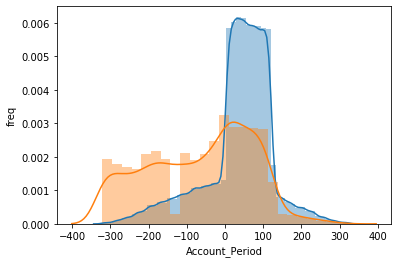

In [70]:
unique_vals = train_data['Fraudster'].unique()
#list of sliced dataframes
targets = [train_data.loc[train_data['Fraudster']==val] for val in unique_vals]

dist_plot = sns.distplot(targets[0]['Account_Period'])
sns.distplot(targets[1]['Account_Period'])
dist_plot.set(xlabel='Account_Period', ylabel='freq')  #

In [83]:
print("Non-Fraud Records with +ve Account_Period:", (targets[0].loc[targets[0]['Account_Period']>=0].shape[0])/targets[0].shape[0])
print("Fraud Records with -ve Account_Period:", (targets[1].loc[targets[1]['Account_Period']<0].shape[0])/targets[1].shape[0])

Non-Fraud Records with +ve Account_Period: 0.7945840448889974
Fraud Records with -ve Account_Period: 0.5759203980099502


In [100]:
def acct_period_status(x):
    if x  >= 0:
        return '+ve'
    else:
        return '-ve'

In [116]:
train_data['Account_Period_Status'] = train_data.loc[:,'Account_Period'].apply(acct_period_status)
test_data['Account_Period_Status'] = test_data.loc[:,'Account_Period'].apply(acct_period_status)

[Text(0, 0.5, 'freq'), Text(0.5, 0, 'Age')]

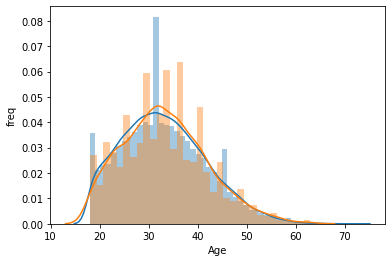

In [76]:
dist_plot = sns.distplot(targets[0]['Age'])
sns.distplot(targets[1]['Age'])
dist_plot.set(xlabel='Age', ylabel='freq')  #'Age' Uniform distb for both Fraudster =  {0,1}

In [87]:
train_data[['Fraudster', 'Age']].groupby('Fraudster').median()  #can be dropped

,Age
Fraudster,
0,32
1,33


[Text(0, 0.5, 'freq'), Text(0.5, 0, 'Order_Value_USD')]

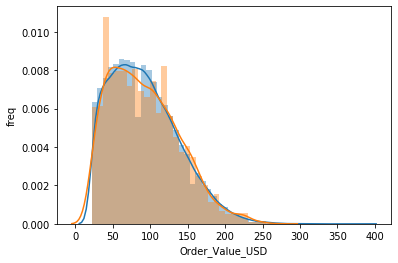

In [75]:
dist_plot = sns.distplot(targets[0]['Order_Value_USD'])
sns.distplot(targets[1]['Order_Value_USD'])
dist_plot.set(xlabel='Order_Value_USD', ylabel='freq')

In [89]:
train_data[['Fraudster', 'Order_Value_USD']].groupby('Fraudster').median() #Feature is dropped

,Order_Value_USD
Fraudster,
0,88
1,88


#### Remove Redundant Features

In [ ]:
train_data.drop(labels=['Merchant_Registration_Date', 'Date_of_Order', 'Account_Period'], axis=1, inplace=True)
test_data.drop(labels=['Merchant_Registration_Date', 'Date_of_Order', 'Account_Period'], axis=1, inplace=True)

#### Note: Numerical Features uniformaly distrib in both Target Classes can be removed !

In [7]:
train_data.drop(labels=['Age', 'Order_Value_USD'], axis=1, inplace=True)
test_data.drop(labels=['Age', 'Order_Value_USD'], axis=1, inplace=True)

train_data[['Fraudster', 'Account_Period_Status']] = train_data[['Fraudster', 'Account_Period_Status']].astype('category') 
test_data[['Account_Period_Status']] = test_data[['Account_Period_Status']].astype('category') 

In [222]:
train_data.isna().sum()

Gender                      0
Order_Source                0
Order_Payment_Method        0
Fraudster                   0
country                  7808
Continent                7751
Quarter                     0
Month                       0
Day                         0
Time_Hour                   0
Account_Period_Status       0
dtype: int64

In [ ]:
train_data.drop(labels=['City', 'Sub_Divisions'], axis = 1, inplace=True)

In [19]:
train_data.drop(['City', 'Sub_Divisions'], inplace=True, axis=1) #Dropped due to 50% of NaNs
train_data

,Gender,Order_Source,Order_Payment_Method,Fraudster,country,Continent,Quarter,Month,Day,Time_Hour,Account_Period_Status
0,F,SEO,Debit Card,0,United States,North America,3,Jul,Monday,10,+ve
1,M,SEO,Internet Banking,0,United Kingdom,Europe,2,Jun,Friday,11,+ve
2,F,SEO,Credit Card,0,Japan,Asia,3,Aug,Monday,10,+ve
3,M,Direct,E-wallet,0,Austria,Europe,3,Jul,Sunday,15,+ve
4,F,SEO,E-wallet,0,China,Asia,2,Apr,Monday,8,-ve
5,M,Ads,Credit Card,0,NaN,NaN,4,Oct,Thursday,9,+ve
6,F,SEO,Credit Card,0,United States,North America,1,Mar,Tuesday,20,+ve
7,M,SEO,Internet Banking,0,China,Asia,2,Apr,Thursday,2,+ve
8,F,SEO,Debit Card,1,Japan,Asia,1,Feb,Friday,16,+ve
9,M,Ads,Credit Card,1,Italy,Europe,1,Jan,Saturday,22,-ve


In [20]:
si = SimpleImputer(strategy='constant', missing_values=np.nan, fill_value='other')
train_data[['country', 'Continent']] = si.fit_transform(X=train_data[['country', 'Continent']])
train_data[['country', 'Continent']] = train_data[['country', 'Continent']].astype('category')
train_data

,Gender,Order_Source,Order_Payment_Method,Fraudster,country,Continent,Quarter,Month,Day,Time_Hour,Account_Period_Status
0,F,SEO,Debit Card,0,United States,North America,3,Jul,Monday,10,+ve
1,M,SEO,Internet Banking,0,United Kingdom,Europe,2,Jun,Friday,11,+ve
2,F,SEO,Credit Card,0,Japan,Asia,3,Aug,Monday,10,+ve
3,M,Direct,E-wallet,0,Austria,Europe,3,Jul,Sunday,15,+ve
4,F,SEO,E-wallet,0,China,Asia,2,Apr,Monday,8,-ve
5,M,Ads,Credit Card,0,other,other,4,Oct,Thursday,9,+ve
6,F,SEO,Credit Card,0,United States,North America,1,Mar,Tuesday,20,+ve
7,M,SEO,Internet Banking,0,China,Asia,2,Apr,Thursday,2,+ve
8,F,SEO,Debit Card,1,Japan,Asia,1,Feb,Friday,16,+ve
9,M,Ads,Credit Card,1,Italy,Europe,1,Jan,Saturday,22,-ve


**-------------------------------------------------------------------**

In [21]:
train_data.iloc[:,:] = train_data.astype('category')
train_data.dtypes

Gender                   category
Order_Source             category
Order_Payment_Method     category
Fraudster                category
country                  category
Continent                category
Quarter                  category
Month                    category
Day                      category
Time_Hour                category
Account_Period_Status    category
dtype: object

In [22]:
X_data = train_data.copy()
X_data.drop(labels='Fraudster', axis=1, inplace=True)
y_data = train_data[['Fraudster']]

In [23]:
print(X_data.dtypes, '\n')
print(y_data.dtypes)

Gender                   category
Order_Source             category
Order_Payment_Method     category
country                  category
Continent                category
Quarter                  category
Month                    category
Day                      category
Time_Hour                category
Account_Period_Status    category
dtype: object 

Fraudster    category
dtype: object


#### Visualize No. of Target Labels:

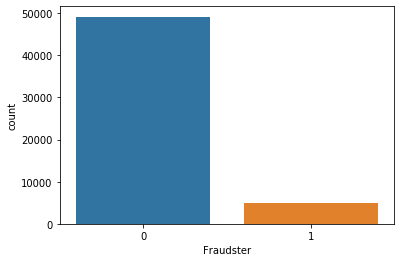

0    0.90731
1    0.09269
Name: Fraudster, dtype: float64

In [24]:
sns.countplot(x='Fraudster', data=y_data)
plt.show()
y_data.Fraudster.value_counts(normalize=True)  #Class Imbalance, stratified sampling needed

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.33, random_state=123, stratify=y_data)
print(y_train['Fraudster'].value_counts())
print(y_val['Fraudster'].value_counts())

0    32955
1     3367
Name: Fraudster, dtype: int64
0    16233
1     1658
Name: Fraudster, dtype: int64


**Model Building 1**: Logistic Regression

In [51]:
X_train.dtypes

Gender                   category
Order_Source             category
Order_Payment_Method     category
country                  category
Continent                category
Quarter                  category
Month                    category
Day                      category
Time_Hour                category
Account_Period_Status    category
dtype: object

In [52]:
# num_attr = list(X_train.select_dtypes('int64').columns)

cat_attr = list(X_train.select_dtypes('category').columns)
# cat_attr = list(set(cat_attr).difference(set(['country','Continent', 'City', 'Sub_Divisions'])))

In [81]:
# Numerical Pipeline: Pipeline has 2 operation - SimpleImputer() + StandardScaler()
# numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])    

# Categorical Pipeline: Pipeline has 2 operation - SimpleImputer() + OneHotEncoder()
categorical_transformer = Pipeline(steps =[('onehot', OneHotEncoder(handle_unknown='ignore'))])
#SimpleImputer strategy ='constant', then fill_values = 'Constant value string written here'

preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, cat_attr)])

In [29]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])
# clf_logreg = Pipeline(steps=[('classifier', LogisticRegression())])

In [30]:
y_train.shape

(36322, 1)

In [31]:
X_train.isna().sum()

Gender                   0
Order_Source             0
Order_Payment_Method     0
country                  0
Continent                0
Quarter                  0
Month                    0
Day                      0
Time_Hour                0
Account_Period_Status    0
dtype: int64

In [32]:
clf_logreg.fit(X = X_train, y = y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat', Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [35]:
test_pred = clf_logreg.predict(X_val)

print(clf_logreg.score(X_val, y_val))

0.9448325973953384


In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Conf Matrix : \n", confusion_matrix(y_val, test_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_val, test_pred))
print("\nTrain DATA Precision", precision_score(y_val, test_pred))
print("\nTrain DATA Recall", recall_score(y_val, test_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_val, test_pred,pos_label=1))
print("\nTrain data f1-score for class '0'",f1_score(y_val, test_pred,pos_label=0))

Conf Matrix : 
 [[16007   226]
 [  761   897]]

Train DATA ACCURACY 0.9448325973953384

Train DATA Precision 0.798753339269813

Train DATA Recall 0.5410132689987938

Train data f1-score for class '1' 0.645091693635383

Train data f1-score for class '0' 0.9700918153995335


**Model 2: Decision Tree Model**

In [37]:
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}


dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

In [38]:
dt_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat', Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [8, 10, 12], 'classifier__min_samples_split': [2, 10, 20], 'classifier__min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
dt_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 2}

In [40]:
test_pred = dt_grid.predict(X_val)

print(dt_grid.score(X_val, y_val))

0.9479626627913476


In [41]:
print("Conf Matrix : \n", confusion_matrix(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Precision", precision_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Recall", recall_score(y_true=y_val, y_pred = test_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=1))
print("\nTraom data f1-score for class '0'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=0))

Conf Matrix : 
 [[16076   157]
 [  774   884]]

Train DATA ACCURACY 0.9479626627913476

Train DATA Precision 0.8491834774255523

Train DATA Recall 0.5331724969843185

Train data f1-score for class '1' 0.6550574286772879

Traom data f1-score for class '0' 0.9718586585255267


#### Model - 3 Random Forest

In [113]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

# param_grid = {"classifier__n_estimators" : [150, 250, 300],
#               "classifier__max_depth" : [5,8,10],
#               "classifier__max_features" : [3, 5, 7],
#               "classifier__min_samples_leaf" : [4, 6, 8, 10]}

param_grid = {"classifier__n_estimators" : [150, 300],
              "classifier__max_depth" : [5,10],
              "classifier__max_features" : [3, 7],
              "classifier__min_samples_leaf" : [4, 10]}

rf_grid = GridSearchCV(clf, param_grid=dt_param_grid, cv=kfold)

In [114]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat', Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [8, 10, 12], 'classifier__min_samples_split': [2, 10, 20], 'classifier__min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [118]:
rf_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 12,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2}

In [116]:
test_pred = dt_grid.predict(X_val)

print(dt_grid.score(X_val, y_val))

0.9479626627913476


In [117]:
print("Conf Matrix : \n", confusion_matrix(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Precision", precision_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Recall", recall_score(y_true=y_val, y_pred = test_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=1))
print("\nTraom data f1-score for class '0'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=0))

Conf Matrix : 
 [[16076   157]
 [  774   884]]

Train DATA ACCURACY 0.9479626627913476

Train DATA Precision 0.8491834774255523

Train DATA Recall 0.5331724969843185

Train data f1-score for class '1' 0.6550574286772879

Traom data f1-score for class '0' 0.9718586585255267


In [119]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}


rf_grid = GridSearchCV(clf, param_grid=dt_param_grid, cv=kfold)

rf_grid.fit(X_train, y_train)
test_pred = rf_grid.predict(X_val)

In [120]:
rf_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 12,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 10}

In [121]:
print("Conf Matrix : \n", confusion_matrix(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Precision", precision_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Recall", recall_score(y_true=y_val, y_pred = test_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=1))
print("\nTraom data f1-score for class '0'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=0))

Conf Matrix : 
 [[16077   156]
 [  773   885]]

Train DATA ACCURACY 0.9480744508412051

Train DATA Precision 0.8501440922190202

Train DATA Recall 0.5337756332931243

Train data f1-score for class '1' 0.6557984438680994

Traom data f1-score for class '0' 0.971919112535139


#### Model-4 Gradient Boosting Trees

In [126]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('GBM',GradientBoostingClassifier())])
gbm_param_grid = {'GBM__max_depth': [6, 8], 'GBM__subsample': [0.8], 'GBM__max_features':[0.3], 
              'GBM__n_estimators': [30, 40]}

gbm_grid = GridSearchCV(clf, param_grid=gbm_param_grid, cv=5)

gbm_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat', Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'GBM__max_depth': [6, 8], 'GBM__subsample': [0.8], 'GBM__max_features': [0.3], 'GBM__n_estimators': [30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [127]:
test_pred = gbm_grid.predict(X_val)

In [128]:
gbm_grid.best_params_

{'GBM__max_depth': 8,
 'GBM__max_features': 0.3,
 'GBM__n_estimators': 40,
 'GBM__subsample': 0.8}

In [129]:
print("Conf Matrix : \n", confusion_matrix(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Precision", precision_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Recall", recall_score(y_true=y_val, y_pred = test_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=1))
print("\nTraom data f1-score for class '0'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=0))

Conf Matrix : 
 [[16081   152]
 [  771   887]]

Train DATA ACCURACY 0.9484098149907775

Train DATA Precision 0.8537054860442733

Train DATA Recall 0.5349819059107358

Train data f1-score for class '1' 0.6577678902484241

Traom data f1-score for class '0' 0.9721021611001964


#### Model - 5 Class Weights of Loss Function

In [137]:
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2],"classifier__min_samples_leaf": [1],
                 "classifier__class_weight":['balanced']}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=10)
dt_grid_bal.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cat', Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6, 8, 10, 12], 'classifier__min_samples_split': [2], 'classifier__min_samples_leaf': [1], 'classifier__class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [138]:
test_pred = dt_grid_bal.predict(X_val)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [139]:
dt_grid_bal.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2}

In [140]:
print("Conf Matrix : \n", confusion_matrix(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Precision", precision_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Recall", recall_score(y_true=y_val, y_pred = test_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=1))
print("\nTraom data f1-score for class '0'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=0))

Conf Matrix : 
 [[16081   152]
 [  771   887]]

Train DATA ACCURACY 0.9484098149907775

Train DATA Precision 0.8537054860442733

Train DATA Recall 0.5349819059107358

Train data f1-score for class '1' 0.6577678902484241

Traom data f1-score for class '0' 0.9721021611001964


#### Model - 6 Using SMOTE

In [167]:
X_train.shape

(36322, 10)

In [168]:
X_train.dtypes

Gender                   category
Order_Source             category
Order_Payment_Method     category
country                  category
Continent                category
Quarter                  category
Month                    category
Day                      category
Time_Hour                category
Account_Period_Status    category
dtype: object

In [193]:
# Categorical Pipeline: Pipeline has 2 operation - SimpleImputer() + OneHotEncoder()
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'constant', fill_value='other')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [194]:
X_train.dtypes

Gender                   category
Order_Source             category
Order_Payment_Method     category
country                  category
Continent                category
Quarter                  category
Month                    category
Day                      category
Time_Hour                category
Account_Period_Status    category
dtype: object

In [195]:
clf = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_pp = pd.DataFrame(clf.transform(X_train).toarray())
X_val_pp = pd.DataFrame(clf.transform(X_val).toarray())
X_train_pp.shape

(36322, 188)

In [217]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
os_data_X, os_data_y = smote.fit_sample(X=X_train_pp, y=y_train)

os_data_X = pd.DataFrame(data=os_data_X)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of Clean Transactions in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of Fraud Transactions",len(os_data_y[os_data_y['y']==1]))
print("Proportion of Clean Transactions data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of Fraud Transactions in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  65910
Number of Clean Transactions in oversampled data 32955
Number of Fraud Transactions 32955
Proportion of Clean Transactions data in oversampled data is  0.5
Proportion of Fraud Transactions in oversampled data is  0.5


In [218]:
clf_dt = Pipeline(steps=[('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

dt_grid_bal.fit(os_data_X,os_data_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6, 8, 10, 12], 'classifier__min_samples_split': [2, 10, 20], 'classifier__min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [227]:
test_pred = dt_grid_bal.predict(X_val_pp)

In [228]:
dt_grid_bal.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 12,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 10}

In [229]:
print("Conf Matrix : \n", confusion_matrix(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Precision", precision_score(y_true=y_val, y_pred = test_pred))
print("\nTrain DATA Recall", recall_score(y_true=y_val, y_pred = test_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=1))
print("\nTraom data f1-score for class '0'",f1_score(y_true=y_val, y_pred = test_pred,pos_label=0))

Conf Matrix : 
 [[15954   279]
 [  761   897]]

Train DATA ACCURACY 0.9418702140741155

Train DATA Precision 0.7627551020408163

Train DATA Recall 0.5410132689987938

Train data f1-score for class '1' 0.6330275229357799

Traom data f1-score for class '0' 0.9684351098700982
